In [1]:
from __future__ import print_function, division
import requests
import pandas as pd
import numpy as np
import os.path
from bs4 import BeautifulSoup
import patsy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

%matplotlib inline

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
import statsmodels.formula.api as smf
from statsmodels.tools.data import _is_using_pandas, _is_recarray
from statsmodels.tools.validation import array_like
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv(r'C:\Users\andro\Metis\module2_repo\combined.csv')

In [3]:
#Limiting 'Pos' column to 2 characters

def char_len(x, fixed_n):
    if len(x) > fixed_n: 
        return x[:fixed_n]
    else:
        return x
    
df['Pos'] = df['Pos'].apply(lambda x: char_len(x,2))
df['Pos'] = df['Pos'].replace(['C-'], 'C')

In [4]:
#Creating dummies
dummy = pd.get_dummies(df['Pos'], drop_first=True)

In [5]:
df.Pos.unique()

array(['PF', 'PG', 'C', 'SG', 'SF', 'F', 'G'], dtype=object)

In [6]:
df = df.drop(columns=['Unnamed: 0','G','PF'])

In [7]:
#Merge dummies
df = df.merge(dummy, left_index=True,right_index=True)
df.head()

,Player,Pos,Age,Tm,GS,MP,FG,FGA,FG%,3P,...,TOV,PTS,YEAR,SALARY,F,G,PF,PG,SF,SG
0,Precious Achiuwa,PF,21,MIA,2,12.3,2.1,3.8,0.556,0.0,...,0.8,5.2,2021,2582160,0,0,1,0,0,0
1,Jaylen Adams,PG,24,MIL,0,2.6,0.1,1.1,0.125,0.0,...,0.0,0.3,2021,449115,0,0,0,1,0,0
2,Steven Adams,C,27,NOP,49,27.9,3.4,5.5,0.616,0.0,...,1.5,7.8,2021,29592695,0,0,0,0,0,0
3,Bam Adebayo,C,23,MIA,47,33.5,7.3,12.9,0.565,0.0,...,2.6,19.1,2021,5115492,0,0,0,0,0,0
4,LaMarcus Aldridge,C,35,TOT,23,25.9,5.4,11.4,0.473,1.2,...,1.0,13.5,2021,17628340,0,0,0,0,0,0


In [8]:
#FE: Adding Approximate Value
FGMi = df['FGA']-df['FG']
FTMi = df['FTA']-df['FT']
Credits = (df['PTS']+df['TRB']+df['AST']+df['STL']+df['BLK'])-(FGMi-FTMi)-df['TOV']
df['AV'] = (Credits**(.75))/21
df=df.fillna(0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[['Age', 'MP', '3P', '2P', 'FT',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 
       'PTS', 'YEAR','F','G','PF','PG','SF','SG','AV']], df['SALARY'], test_size=0.2, random_state=10)

In [27]:
m = LinearRegression()
m.fit(X_train,y_train)
m.score(X_train,y_train)

0.5685378757996102

In [11]:
m.score(X_test,y_test)

0.5750267396467824

In [23]:
#Polynomial Regression

from sklearn.preprocessing import PolynomialFeatures
p = PolynomialFeatures(degree=2)
X_train_poly = p.fit_transform(X_train)
m.fit(X_train_poly,y_train)
m.score(X_train_poly,y_train)

0.6886302182469829

In [24]:
m.score(p.transform(X_test),y_test)

0.6817968457435686

In [25]:
#LassoCV

lasso = LassoCV()
p = PolynomialFeatures(degree=2)
#Apply poly transform
X_train_poly = p.fit_transform(X_train)
X_test_poly = p.fit_transform(X_test)
s = StandardScaler()
#Apply scaler
X_train_poly_scaled = s.fit_transform(X_train_poly)
X_test_poly_scaled = s.fit_transform(X_test_poly)

lasso.fit(X_train_poly_scaled,y_train)
lasso.score(X_train_poly_scaled,y_train)

C:\Users\andro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17403424930264.0, tolerance: 13257398128100.172
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\andro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16350581319088.0, tolerance: 13257398128100.172
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\andro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25481111827464.0, tolerance: 13257398128100.172
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\andro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: Co

C:\Users\andro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 566689370353944.0, tolerance: 16624456421079.543
  model = cd_fast.enet_coordinate_descent(


0.6478779204341674

In [15]:
lasso.score(X_test_poly_scaled,y_test)

0.6485856376944819

In [16]:
list(zip(X_train.columns, lasso.coef_))

[('Age', 0.0),
 ('MP', 0.0),
 ('3P', -0.0),
 ('2P', -189381.48190797394),
 ('FT', -0.0),
 ('TRB', -126.99575307526375),
 ('AST', -259188.51431478202),
 ('STL', -535285.0330463477),
 ('BLK', 0.0),
 ('TOV', -0.0),
 ('PTS', -0.0),
 ('YEAR', -0.0),
 ('F', 818326.0660838442),
 ('G', -0.0),
 ('PF', -53380.88141088844),
 ('PG', 0.0),
 ('SF', -15342.408222811968),
 ('SG', 0.0),
 ('AV', -0.0)]

In [17]:
selected_columns = ['Age', 'MP', '3P', '2P', 'FT',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 
       'PTS', 'YEAR','F','G','PF','PG','SF','SG','AV']

np.random.seed(6)

scaler = StandardScaler()

X_train_collinear = X_train.loc[:,selected_columns]
X_std = scaler.fit_transform(X_train_collinear.values)
lr_model_ridge = RidgeCV(alphas = [0.1, 1.0, 10.0])
#lr_model_ridge.fit(X_train_collinear, y_train)
lr_model_ridge.fit(X_std, y_train)

#list(zip(X_train_collinear.columns, lr_model_ridge.coef_))
list(zip(X_train_collinear, lr_model_ridge.coef_))

[('Age', 1900245.746051401),
 ('MP', -902568.4031844139),
 ('3P', 277465.9616549164),
 ('2P', 251649.71882582456),
 ('FT', 997134.7957209796),
 ('TRB', 2519541.3127245605),
 ('AST', 2480395.016233772),
 ('STL', 66794.61689321697),
 ('BLK', 499877.48130229115),
 ('TOV', -467192.91103423014),
 ('PTS', 3908709.0961064333),
 ('YEAR', 1019288.0419373773),
 ('F', -61019.08661196381),
 ('G', -101635.01323973387),
 ('PF', -168820.82794250362),
 ('PG', -855922.2149009109),
 ('SF', -118103.34746275842),
 ('SG', -439735.08500635624),
 ('AV', -3487477.8972201645)]

In [18]:
lr_model_ridge.score(X_std, y_train)

0.5684703962673583

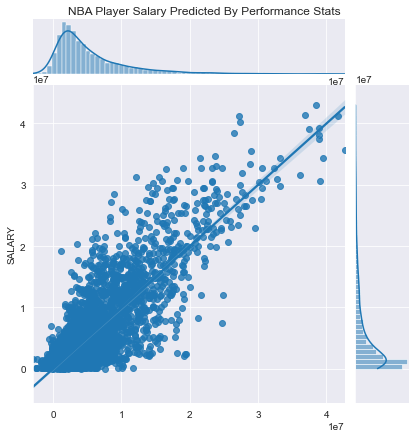

In [20]:
preds = m.predict(X_train_poly)
ax = sns.jointplot(x=preds,y=y_train, kind='reg')
ax.fig.suptitle('NBA Player Salary Predicted By Performance Stats')
ax.fig.subplots_adjust(top=0.95)

In [30]:
df['res'] = (m.predict(df[['Age', 'MP', '3P', '2P', 'FT',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 
       'PTS', 'YEAR','F','G','PF','PG','SF','SG','AV']])-df['SALARY']).astype('int64')
df = df.drop(columns=['F','G','PF','PG','SF','SG'])

df.sort_values(['res']).tail(10)

,Player,Pos,Age,Tm,GS,MP,FG,FGA,FG%,3P,...,TRB,AST,STL,BLK,TOV,PTS,YEAR,SALARY,AV,res
315,Donovan Mitchell,SG,24,UTA,50,33.6,9.0,20.6,0.438,3.3,...,4.5,5.3,1.0,0.3,2.7,26.3,2021,5195501,0.516344,13442105
118,Luka Doncic,PG,21,DAL,47,35.1,10.2,21.0,0.485,3.0,...,8.1,8.7,1.0,0.6,4.3,28.5,2021,8049360,0.666044,13527802
1408,Dwyane Wade,SG,37,MIA,2,26.2,5.8,13.3,0.433,1.2,...,4.0,4.2,0.8,0.5,2.3,15.0,2019,2393887,0.373787,13798024
482,Trae Young,PG,22,ATL,50,34.3,7.8,17.8,0.435,2.3,...,4.0,9.5,0.8,0.2,4.3,25.4,2021,6571800,0.559325,14077175
884,Pascal Siakam,PF,25,TOR,60,35.2,8.3,18.4,0.453,2.2,...,7.3,3.5,1.0,0.9,2.5,22.9,2020,2351838,0.517957,14624049
1007,Devin Booker,SG,22,PHO,64,35.0,9.2,19.6,0.467,2.1,...,4.1,6.8,0.9,0.2,4.1,26.6,2019,3314365,0.533994,14675887
1964,Giannis Antetokounmpo,SF,22,MIL,80,35.6,8.2,15.7,0.521,0.6,...,8.8,5.4,1.6,1.9,2.9,22.9,2017,2995420,0.640683,14736420
606,Luka Doncic,PG,20,DAL,61,33.6,9.5,20.6,0.463,2.8,...,9.4,8.8,1.0,0.2,4.3,28.8,2020,7683360,0.685223,15220874
946,Trae Young,PG,21,ATL,60,35.3,9.1,20.8,0.437,3.4,...,4.3,9.3,1.1,0.1,4.8,29.6,2020,6273000,0.598161,15575691
1695,Nikola Jokic,C,22,DEN,73,32.6,6.7,13.5,0.499,1.5,...,10.7,6.1,1.2,0.8,2.8,18.5,2018,1471382,0.585827,15681131


In [31]:
df.sort_values(['res']).head(10)

,Player,Pos,Age,Tm,GS,MP,FG,FGA,FG%,3P,...,TRB,AST,STL,BLK,TOV,PTS,YEAR,SALARY,AV,res
1641,Gordon Hayward,SF,27,BOS,1,5.0,1.0,2.0,0.500,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,2018,29727900,0.080085,-27518648
457,John Wall,PG,30,HOU,34,32.0,7.4,18.1,0.410,2.1,...,3.3,6.8,1.1,0.8,3.4,20.8,2021,41254920,0.452041,-23121182
359,Chris Paul,PG,35,PHO,51,31.8,6.1,12.5,0.491,1.3,...,4.7,8.7,1.4,0.2,2.3,16.2,2021,41358814,0.495222,-22205483
176,Blake Griffin,PF,31,TOT,21,27.6,3.7,9.4,0.395,1.7,...,4.9,3.4,0.7,0.2,1.5,11.1,2021,33900241,0.342801,-21404383
2,Steven Adams,C,27,NOP,49,27.9,3.4,5.5,0.616,0.0,...,8.8,1.9,1.0,0.7,1.5,7.8,2021,29592695,0.414401,-21202847
1158,Gordon Hayward,PF,28,BOS,18,25.9,4.1,8.8,0.466,1.1,...,4.5,3.4,0.9,0.3,1.5,11.5,2019,31214295,0.359316,-20994681
838,Chris Paul,PG,34,OKC,70,31.5,6.2,12.7,0.489,1.6,...,5.0,6.7,1.6,0.2,2.3,17.6,2020,38506482,0.495222,-20918556
583,Mike Conley,PG,32,UTA,41,29.0,4.9,12.1,0.409,2.0,...,3.2,4.4,0.8,0.1,2.0,14.4,2020,32511623,0.350173,-19991431
593,Stephen Curry,PG,31,GSW,5,27.8,6.6,16.4,0.402,2.4,...,5.2,6.6,1.0,0.4,3.2,20.8,2020,40231758,0.467138,-19737621
96,Mike Conley,PG,33,UTA,43,29.7,5.7,12.7,0.452,2.8,...,3.5,5.4,1.3,0.1,1.9,16.6,2021,34502132,0.423052,-19643089


In [ ]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

RMSE(y,)